In [1]:
import numpy as np
import os
import timeit
import glob 
import pandas as pd
import time
import multiprocessing as mp 
import logging
import sys 
from pathlib import Path
import matplotlib.pyplot as plt 

Matplotlib created a temporary config/cache directory at /scratch/slurm-job.725485/matplotlib-73z06c6p because the default path (/cluster/customapps/biomed/grlab/users/prelotla/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Order 
- Uniprot 
- Sample init
- Sample expression 
- Sample cohort 
- annotation 
- GTEX?

In [2]:
def filter_cancer_cohort(df, n_samples, threshold_column ):
    df = df.loc[df[threshold_column] >= n_samples]    
    return df
        

In [3]:
def get_threshold_colname(threshold, tag):
    if (threshold is not None) or (threshold > 0 ):
        threshold_column = f'{tag}filter >={threshold}'
    else:
        threshold_column = f'{tag}filter >{expression_threshold}'
    return threshold_column

In [4]:
def filter_single_col(df, threshold, colname):
    if threshold:
        df = df.loc[df[colname] >= threshold, :]
    else:
        df = df.loc[df[colname] >threshold, :]
    return df

In [5]:
intermediate_output = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_intermediate/complete_cancer_candidates_missing_162_45.tsv.gz'

In [6]:
df = pd.read_csv(intermediate_output, sep = '\t')

In [7]:
df.columns

Index(['kmer', 'gtexCohortfilter >0.0', 'gtexCohortfilter >=1.0',
       'gtexCohortfilter >=2.0', 'gtexCohortfilter >=3.0',
       'gtexCohortfilter >=5.0', 'gtexCohortfilter >=10.0', 'coord',
       'junctionAnnotated', 'readFrameAnnotated', 'isCrossJunction', 'batch',
       'cancerCohortfilter >0.0', 'cancerCohortfilter >=1.0',
       'cancerCohortfilter >=2.0', 'cancerCohortfilter >=3.0',
       'cancerCohortfilter >=5.0', 'cancerCohortfilter >=10.0',
       'TCGAC8A12P01A11RA11507all', 'TCGAAOA0JM01A21RA05607all',
       'TCGABHA18V01A11RA12D07all', 'TCGAA2A0D201A21RA03407all',
       'TCGAA2A0SX01A12RA08407all', 'isAnnotated'],
      dtype='object')

In [8]:
df.head()

,kmer,gtexCohortfilter >0.0,gtexCohortfilter >=1.0,gtexCohortfilter >=2.0,gtexCohortfilter >=3.0,gtexCohortfilter >=5.0,gtexCohortfilter >=10.0,coord,junctionAnnotated,readFrameAnnotated,...,cancerCohortfilter >=2.0,cancerCohortfilter >=3.0,cancerCohortfilter >=5.0,cancerCohortfilter >=10.0,TCGAC8A12P01A11RA11507all,TCGAAOA0JM01A21RA05607all,TCGABHA18V01A11RA12D07all,TCGAA2A0D201A21RA03407all,TCGAA2A0SX01A12RA08407all,isAnnotated
0,WYITRSGIA,3290.0,1969.0,861.0,394.0,89.0,4.0,92347505:92347506:92349915:92349941:None:None,False,False,...,138,82,26,5,0.000000,0.000000,0.000000,4.102634,0.0,NaN
1,WYITRSGIA,572.0,545.0,243.0,130.0,27.0,2.0,92347505:92347506:92349915:92349941:None:None,False,False,...,138,82,26,5,0.000000,0.000000,0.000000,4.102634,0.0,NaN
2,ISSQSRVEK,278.0,261.0,82.0,29.0,7.0,0.0,92379851:92379859:92493866:92493885:None:None,False,False,...,10,2,0,0,0.000000,0.000000,2.474321,0.000000,0.0,NaN
3,RSGDEEKYP,7350.0,4622.0,2653.0,1745.0,1126.0,734.0,92600493:92600508:92611313:92611325:None:None,True,True,...,641,520,348,170,2.922641,2.102386,1.237161,0.000000,0.0,1.0
4,HLKMKMFQI,146.0,136.0,42.0,20.0,3.0,1.0,92379850:92379859:92496416:92496434:None:None,False,False,...,16,2,0,0,2.922641,0.000000,0.000000,0.000000,0.0,NaN


In [9]:
target_sample = 'TCGAC8A12P01A11RA11507all'
threshold_target = 3.0
threshold_cancer_cohort = 3.0
n_samples_cancer = 520 

threshold_normal_cohort = 10.0 
n_samples_normal = 15

tag_cancer = 'cancerCohort'
tag_normal = 'gtexCohort'

threshold_column = get_threshold_colname(threshold_cancer_cohort, tag_cancer)
threshold_column_normal = get_threshold_colname(threshold_normal_cohort, tag_normal)
adjusted_threshold_col = 'tmp_cancer_cohort'
max_threshold_col = 'tmp_normal_max'

In [10]:
# Make correction for number samples passing theshold in cohort. We want to exclude the target sample in counting
df[adjusted_threshold_col] = df[threshold_column]
df.loc[df[target_sample] >= threshold_cancer_cohort, adjusted_threshold_col] -=1 

In [11]:
df.head(10)

,kmer,gtexCohortfilter >0.0,gtexCohortfilter >=1.0,gtexCohortfilter >=2.0,gtexCohortfilter >=3.0,gtexCohortfilter >=5.0,gtexCohortfilter >=10.0,coord,junctionAnnotated,readFrameAnnotated,...,cancerCohortfilter >=3.0,cancerCohortfilter >=5.0,cancerCohortfilter >=10.0,TCGAC8A12P01A11RA11507all,TCGAAOA0JM01A21RA05607all,TCGABHA18V01A11RA12D07all,TCGAA2A0D201A21RA03407all,TCGAA2A0SX01A12RA08407all,isAnnotated,tmp_cancer_cohort
0,WYITRSGIA,3290.0,1969.0,861.0,394.0,89.0,4.0,92347505:92347506:92349915:92349941:None:None,False,False,...,82,26,5,0.000000,0.000000,0.000000,4.102634,0.000000,NaN,82
1,WYITRSGIA,572.0,545.0,243.0,130.0,27.0,2.0,92347505:92347506:92349915:92349941:None:None,False,False,...,82,26,5,0.000000,0.000000,0.000000,4.102634,0.000000,NaN,82
2,ISSQSRVEK,278.0,261.0,82.0,29.0,7.0,0.0,92379851:92379859:92493866:92493885:None:None,False,False,...,2,0,0,0.000000,0.000000,2.474321,0.000000,0.000000,NaN,2
3,RSGDEEKYP,7350.0,4622.0,2653.0,1745.0,1126.0,734.0,92600493:92600508:92611313:92611325:None:None,True,True,...,520,348,170,2.922641,2.102386,1.237161,0.000000,0.000000,1.0,520
4,HLKMKMFQI,146.0,136.0,42.0,20.0,3.0,1.0,92379850:92379859:92496416:92496434:None:None,False,False,...,2,0,0,2.922641,0.000000,0.000000,0.000000,0.000000,NaN,2
5,ELSEFVSRL,3.0,3.0,2.0,1.0,0.0,0.0,92345764:92345787:92347411:92347415:None:None,False,False,...,185,99,31,0.000000,0.000000,0.000000,2.735089,2.280385,NaN,185
6,ELSEFVSRL,1256.0,1218.0,679.0,406.0,142.0,13.0,92345764:92345787:92347411:92347415:None:None,False,False,...,185,99,31,0.000000,0.000000,0.000000,2.735089,2.280385,NaN,185
7,AAPAGQGLN,8641.0,6957.0,4789.0,3211.0,1347.0,191.0,92611374:92611393:92612522:92612530:None:None,True,False,...,1097,1094,1062,21.919810,73.583517,24.743212,27.350895,30.785193,NaN,1096
8,AAPAGQGLN,9102.0,9098.0,8922.0,8694.0,7941.0,5707.0,92611374:92611393:92612522:92612530:None:None,True,False,...,1097,1094,1062,21.919810,73.583517,24.743212,27.350895,30.785193,NaN,1096
9,TWYITRSGI,3290.0,1969.0,861.0,394.0,89.0,4.0,92347502:92347506:92349915:92349938:None:None,False,False,...,82,26,5,0.000000,0.000000,0.000000,4.102634,0.000000,NaN,82


In [12]:
df.shape

(14469694, 25)

In [13]:
df = filter_single_col(df, 0, target_sample)
df.shape

(7796235, 25)

In [14]:
df = filter_single_col(df, threshold_target, target_sample)
df.shape

(4555938, 25)

In [15]:
df = filter_cancer_cohort(df, n_samples_cancer, adjusted_threshold_col)
df.shape

(3565914, 25)

In [16]:
threshold_column

'cancerCohortfilter >=3.0'

(array([   4002.,    7421.,   40344.,    5060.,    6283.,   10577.,
          12324.,    6622.,    5024.,    7275.,    3014.,    5006.,
           6787.,   74159.,    5294.,    4673.,   15335.,   25783.,
           7514.,    4652.,    6741.,   14661.,    2631.,    6513.,
          14130.,   13266.,    6237.,   15371.,    8725.,    5545.,
           3769.,   13161.,   23972.,   11751.,    5843.,    4079.,
          71010.,   35037.,    6187.,    4800.,   49834.,    5884.,
           4274.,    6257.,    4727.,   59218.,    6835.,    8902.,
          10464.,    6498.,   12121.,   26011.,   27247.,    7083.,
           6745.,   11728.,    8541.,   13767.,   10623.,   15349.,
          16608.,    8110.,   10111.,    6647.,   10186.,   12726.,
          65612.,   22938.,    6270.,   87584.,   12784.,   11366.,
         102569.,    8043.,   19418.,   11599.,   23697.,   11759.,
           8895.,   64052.,   90201.,   31985.,   35747.,   16089.,
          36898.,   24705.,   52791.,   27781., 

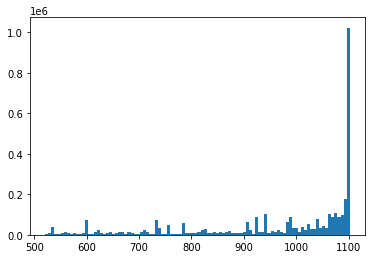

In [17]:
plt.hist(df[threshold_column], bins = 100)

(array([   4002.,    7421.,   40344.,    5060.,    6283.,   10577.,
          12324.,    6622.,    5024.,    7275.,    3014.,    5006.,
           6787.,   74159.,    5294.,    4673.,   15335.,   25783.,
           7514.,    4652.,    6741.,   14661.,    2631.,    6513.,
          14130.,   13266.,    6237.,   15371.,    8725.,    5545.,
           3769.,   13161.,   23972.,   11751.,    5843.,    4079.,
          71010.,   35037.,    6187.,    4800.,   49834.,    5884.,
           4274.,    6257.,    4727.,   59218.,    6835.,    8902.,
          10464.,    6498.,   12121.,   26011.,   27247.,    7083.,
           6745.,   11728.,    8541.,   13767.,   10623.,   15349.,
          16608.,    8110.,   10111.,    6647.,   10186.,   12726.,
          65612.,   22938.,    6270.,   87584.,   12784.,   11366.,
         102569.,    8043.,   19418.,   11599.,   23697.,   11759.,
           8895.,   64052.,   90201.,   31985.,   35747.,   16089.,
          36898.,   24705.,   52791.,   27781., 

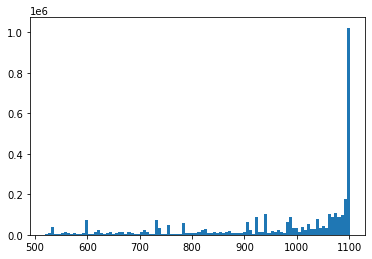

In [18]:
plt.hist(df[adjusted_threshold_col], bins = 100)

In [19]:
df[target_sample].describe()

count    3.565914e+06
mean     4.555620e+02
std      2.736407e+03
min      4.383962e+00
25%      8.767924e+00
50%      2.045849e+01
75%      1.183670e+02
max      1.073778e+05
Name: TCGAC8A12P01A11RA11507all, dtype: float64

(array([3.35505e+06, 8.92110e+04, 2.67660e+04, 1.66580e+04, 7.85000e+03,
        1.16470e+04, 1.12960e+04, 7.01000e+03, 8.22000e+03, 3.52800e+03,
        4.17800e+03, 2.42300e+03, 2.14000e+03, 5.67000e+02, 1.56900e+03,
        1.45100e+03, 1.10500e+03, 9.90000e+02, 6.41000e+02, 2.62000e+02,
        1.05800e+03, 6.84000e+02, 2.91000e+02, 3.42000e+02, 3.36000e+02,
        1.80200e+03, 1.60000e+02, 1.50000e+03, 1.70000e+01, 1.30000e+01,
        3.70000e+02, 2.44000e+02, 3.03000e+02, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 4.87000e+02, 2.76700e+03, 0.00000e+00,
        3.20000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 5.50000e+01,
        1.27100e+03, 0.00000e+00, 0.00000e+00, 1.10000e+01, 2.70000e+01,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 9.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.81000e+02,
        0.00000e+00, 7.38000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

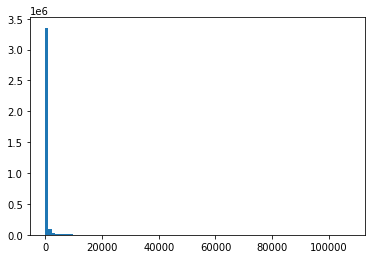

In [20]:
plt.hist(df[target_sample], bins = 100)

In [21]:
df[[adjusted_threshold_col, target_sample]]

,tmp_cancer_cohort,TCGAC8A12P01A11RA11507all
7,1096,21.919810
8,1096,21.919810
17,1089,11.690565
19,1096,21.919810
20,1096,21.919810
...,...,...
14469146,701,4.383962
14469147,701,4.383962
14469148,701,4.383962
14469149,701,4.383962


In [22]:
# GTEX

In [24]:
def max_recurrence_over_kmer(df, threshold_column, new_maxcol):
    df = df[['kmer', threshold_column]].groupby('kmer').max()
    df = df.reset_index()
    df = df.rename({threshold_column_normal: new_maxcol}, axis = 1)
    return df 

In [27]:
df.shape

(3565914, 25)

In [30]:
threshold_column_normal

'gtexCohortfilter >=10.0'

In [34]:
df.loc[df['kmer'] == 'AAAAADHPP', :]

,kmer,gtexCohortfilter >0.0,gtexCohortfilter >=1.0,gtexCohortfilter >=2.0,gtexCohortfilter >=3.0,gtexCohortfilter >=5.0,gtexCohortfilter >=10.0,coord,junctionAnnotated,readFrameAnnotated,...,cancerCohortfilter >=3.0,cancerCohortfilter >=5.0,cancerCohortfilter >=10.0,TCGAC8A12P01A11RA11507all,TCGAAOA0JM01A21RA05607all,TCGABHA18V01A11RA12D07all,TCGAA2A0D201A21RA03407all,TCGAA2A0SX01A12RA08407all,isAnnotated,tmp_cancer_cohort
10618619,AAAAADHPP,8910.0,8249.0,7221.0,6150.0,4196.0,1570.0,136800153:136800169:136800388:136800399:None:None,True,False,...,718,571,294,4.383962,0.0,2.474321,0.0,1.140192,NaN,717
10618620,AAAAADHPP,9475.0,9393.0,8909.0,8100.0,5958.0,2619.0,136800153:136800169:136800388:136800399:None:None,True,False,...,718,571,294,4.383962,0.0,2.474321,0.0,1.140192,NaN,717
10618621,AAAAADHPP,9475.0,9393.0,8909.0,8100.0,5958.0,2619.0,136800153:136800169:136800388:136800399:None:None,True,False,...,718,571,294,4.383962,0.0,2.474321,0.0,1.140192,NaN,717
10618622,AAAAADHPP,9475.0,9393.0,8909.0,8100.0,5958.0,2619.0,136800153:136800169:136800388:136800399:None:None,True,False,...,718,571,294,4.383962,0.0,2.474321,0.0,1.140192,NaN,717
10618623,AAAAADHPP,8898.0,8884.0,8518.0,8120.0,7187.0,4737.0,136800153:136800169:136800388:136800399:None:None,True,False,...,718,571,294,4.383962,0.0,2.474321,0.0,1.140192,NaN,717


In [29]:
max_recurrence_over_kmer(df, threshold_column_normal, max_threshold_col ).head()

,kmer,tmp_normal_max
0,AAAAAAADS,9437.0
1,AAAAAADSR,NaN
2,AAAAAAPGR,9470.0
3,AAAAAAVGR,9382.0
4,AAAAADHPP,4737.0


In [ ]:
max_threshold_gtex.head()


In [ ]:
 (df[base_filter_column] >= n_samples_lim_normal)
    

In [ ]:
df[filter_column] >= base_sample)

#background 
kmer a expressed with 0, 1, 150 samples >=10 
Threshold is 
>= 1 sample >= 10 reads ---> Max as well because >= 10 reads has been seen as well 
Need to check if in any instance (! MAX) , we saw the number of reads >=10 in n_sample = 1. Present
>= 10 samples >0 reads. ---> logical max on n_samples on reurrence 
Number of samples
Examples 
kmer b expressed with 0, 1, 150 samples >0 
We need to check if in any instance, we saw number od reads >0 in n_sample >=10
Do the max again!

In [ ]:
n_samples with highest recurrence  >0 reads 

In [ ]:
df[res_column] = df.loc[(df[filter_column] >= base_sample) \
                        and (df[base_filter_column] >= n_samples_lim_normal)]